Data sourced from Kaggle competition [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview)

In [1]:
# import core libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import joblib

In [3]:
# pre-processing

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

import nltk
from textblob import TextBlob
from langdetect import detect

import contractions

In [4]:
# modelling

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [5]:
# metrics/evaluation

import scikitplot as skplt
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [6]:
# instantiating the train and test sets

train = pd.read_csv('data/train.csv')
test =  pd.read_csv('data/test.csv')

In [7]:
# combining the train and test sets for the purpose of EDA and Data Cleaning/Feature Engineering

df = pd.concat([train, test], ignore_index=True)

In [8]:
print("Training Dataframe Shape: {}".format(str(train.shape)))
print("Test Dataframe Shape: {}".format(str(test.shape)))
print("Combined Dataframe Shape: {}".format(str(df.shape)))

Training Dataframe Shape: (7613, 5)
Test Dataframe Shape: (3263, 4)
Combined Dataframe Shape: (10876, 5)


In [9]:
# example of tweets

df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10876 entries, 0 to 10875
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        10876 non-null  int64  
 1   keyword   10789 non-null  object 
 2   location  7238 non-null   object 
 3   text      10876 non-null  object 
 4   target    7613 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 425.0+ KB


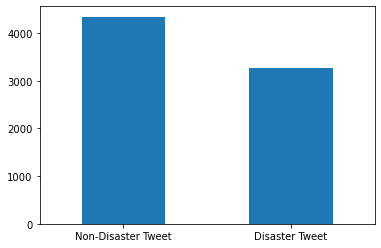

In [11]:
df.target.value_counts().plot.bar()

plt.xticks([0,1], ['Non-Disaster Tweet', 'Disaster Tweet'], rotation=0)

plt.show()

### Dealing with null values

In [12]:
# null values in the training set

df.isnull().sum()

id             0
keyword       87
location    3638
text           0
target      3263
dtype: int64

In [13]:
# creating a new category for the null keyword and location values

df.fillna({'keyword': 'unknown', 'location': 'unknown'},inplace=True)

### Keyword

In [14]:
keyword = df.keyword.apply(lambda x: "No" if x=="unknown" else "Yes")

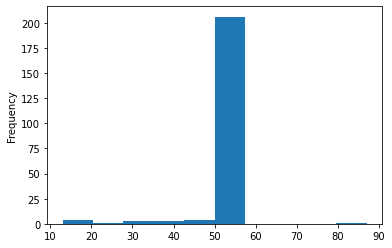

In [15]:
df.keyword.value_counts().plot.hist()

plt.show()

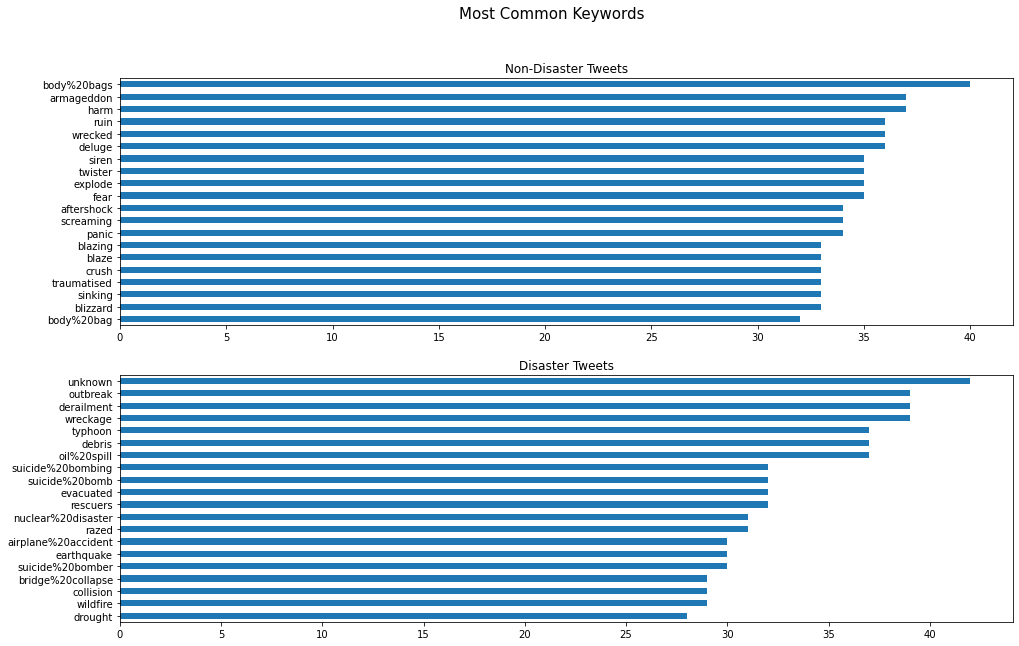

In [16]:
fig,ax = plt.subplots(2,1,figsize=(16,10))

df[df.target==0].keyword.value_counts(ascending=True).tail(20).plot.barh(ax=ax[0])
df[df.target==1].keyword.value_counts(ascending=True).tail(20).plot.barh(ax=ax[1])

ax[0].set_title('Non-Disaster Tweets')
ax[1].set_title('Disaster Tweets')

fig.suptitle('Most Common Keywords', fontsize=15)

plt.show()

In [20]:
# cleaning the keyword column

df.replace({'keyword': '%20'}, {'keyword': ' '}, inplace=True, regex=True)

In [21]:
df[df.keyword=='body_bags'].text.head()

1018    @FoxNews @JenGriffinFNC When you call to repor...
1019    Micom 2015 Summer Contrast Candy Color Bowknot...
1020    HOBO Hobo Vintage Shira Convertible BÛ_ $238....
1021    Child Shoulder Bags PVC Shoulder Book Bag Cart...
1022    Womens Buckle Casual Stylish Shoulder Handbags...
Name: text, dtype: object

My takings from this is that the keywords column won't be very helpful in determining whether a tweet is related to a disaster or not. I would theorize that the keywords were used to decide which tweets should be included in this dataset, though, as they refer to ambiguous topics that may or may not be natural disasters.

### Location

In [26]:
# given how messy and the location column is, it's unlikely that we'll be able to clean it for modelling purposes

df.location.value_counts().head(20)

unknown            3638
USA                 141
New York            109
United States        65
London               58
Canada               42
Nigeria              40
Worldwide            35
India                35
Los Angeles, CA      34
UK                   33
Kenya                32
Washington, DC       31
Mumbai               28
United Kingdom       26
Australia            25
California           25
Los Angeles          24
San Francisco        23
Chicago, IL          23
Name: location, dtype: int64

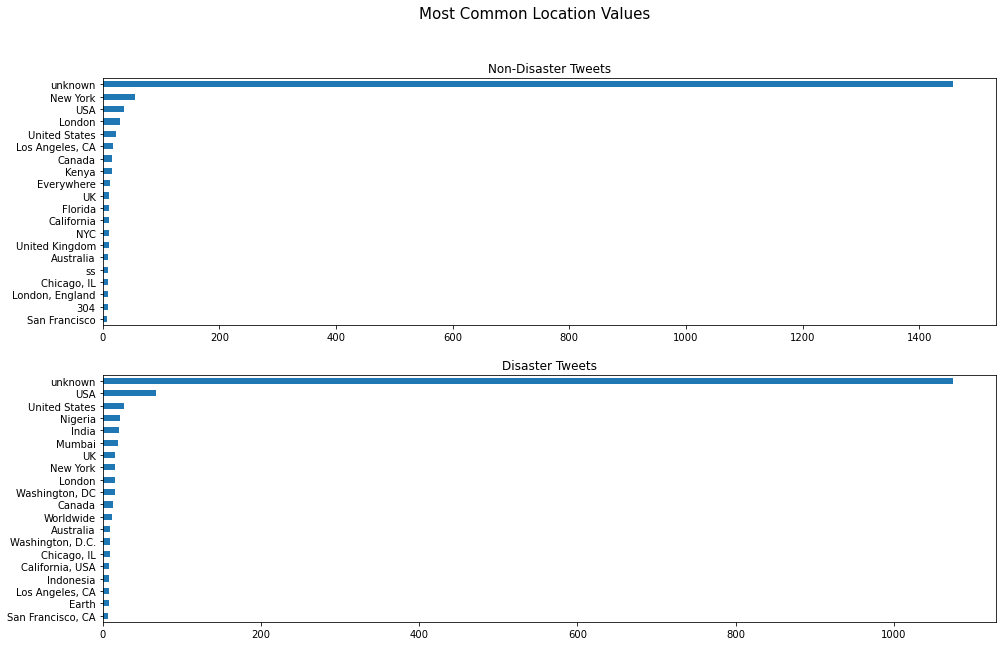

In [27]:
fig,ax = plt.subplots(2,1,figsize=(16,10))

df[df.target==0].location.value_counts(ascending=True).tail(20).plot.barh(ax=ax[0])
df[df.target==1].location.value_counts(ascending=True).tail(20).plot.barh(ax=ax[1])

ax[0].set_title('Non-Disaster Tweets')
ax[1].set_title('Disaster Tweets')

fig.suptitle('Most Common Location Values', fontsize=15)

plt.show()

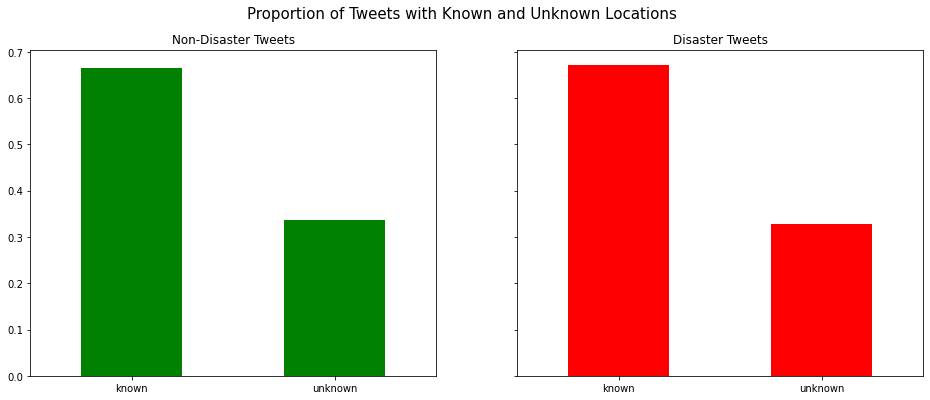

In [28]:
fig,ax = plt.subplots(1,2,figsize=(16,6),sharey=True)

df[df.target==0].location.apply(lambda x: "unknown" if x=="unknown" else "known").value_counts(normalize=True).plot.bar(ax=ax[0], color='g', rot=0)
df[df.target==1].location.apply(lambda x: "unknown" if x=="unknown" else "known").value_counts(normalize=True).plot.bar(ax=ax[1], color='r', rot=0)

ax[0].set_title('Non-Disaster Tweets')
ax[1].set_title('Disaster Tweets')
fig.suptitle('Proportion of Tweets with Known and Unknown Locations', fontsize=15)

plt.show()

Given that the majority of tweets don't have a known location and there doesn't seem to be any importance on whether a tweet's location is known depending on which target value it has, I don't think that location will be a useful predictor.

In [112]:
cvec_loc = CountVectorizer(lowercase=True,strip_accents='unicode',ngram_range=(1,1))

In [113]:
cvec_mat = cvec_loc.fit_transform(df.location)

In [114]:
loc_df = pd.DataFrame(cvec_mat.toarray(),columns=cvec_loc.get_feature_names())

# vocab this!!

In [115]:
# pd.options.display.max_rows = 100

In [116]:
usa_values = ['usa', 'united states']
eu_values = ['united kingdom', ' uk', 'london']


ny_values = ['new york', ' ny', 'brooklyn']
ca_values = ['california','los angeles', 'san francisco', ' ca', 'san diego']
dc_values = ['washington', ' dc']

uk_values

NameError: name 'uk_values' is not defined

In [119]:
df[df.location.str.contains('africa',case=False)]#['target'].value_counts(normalize='all')

,id,keyword,location,text,target
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1.0
56,80,ablaze,South Africa,TRUCK ABLAZE : R21. VOORTREKKER AVE. OUTSIDE O...,1.0
796,1154,blight,"Johannesburg, South Africa",'If you are going to achieve excellence in big...,0.0
1357,1959,burning buildings,"Nelspruit, South Africa",Strikers in Phalaborwa striking over the CHINE...,1.0
1617,2336,collapse,"Sandton, South Africa",SA MP. Steel and ferrochrome industry on verge...,0.0
1726,2489,collided,"Johannesburg, South Africa",2 pple have been confirmed dead and over 20 re...,1.0
2281,3275,demolish,South Africa,Yea so I'm gonna demolish all those boundaries...,0.0
2430,3492,derailed,"Durban, South Africa",Fun with my girls! @ Joe Cools - Durban Main P...,0.0
3096,4444,electrocute,South Africa,@el_torro_loco We can hear the conversation no...,0.0
3280,4706,epicentre,Africa,RT @calestous: Tanzania elephant population de...,1.0


In [67]:
loc_df.sum().sort_values(ascending=False).iloc[0:100]

unknown         3641
usa              375
new              311
ca               211
york             204
london           154
united           137
canada           129
uk               125
city             123
ny               113
california       113
san              111
england          105
washington       100
australia         91
states            87
los               87
angeles           86
tx                84
nigeria           83
texas             81
fl                75
india             71
south             71
world             69
worldwide         69
north             66
dc                62
chicago           62
nc                58
il                55
florida           55
pa                54
francisco         54
st                51
va                50
kingdom           49
nyc               48
ga                48
jersey            48
west              46
mumbai            46
kenya             46
colorado          46
mi                45
earth             44
toronto      

# Text

### Language

In [ ]:
# checking that all tweets are in English

# lang_series = df.text.apply(lambda x: detect(x))

In [ ]:
# saving lang_series as a joblib file

# joblib.dump(lang_series, 'jlib_files/lang_series.jlib')

In [ ]:
# loading lang_series jlib file

lang_series = joblib.load('jlib_files/lang_series.jlib')

df['language'] = lang_series

In [ ]:
df[df.language != 'en'].sample(5)

It seems that the language detector function isn't doing a very good job of picking up some of the tweets' language. Regardless, it seems that all of the tweets are in English so we don't have to worry about dealing with other languages.

In [ ]:
# dropping language column from dataset

df.drop('language', 1, inplace=True)

### Countvectorisation for EDA

In [ ]:
cvec = CountVectorizer(stop_words='english',ngram_range=(1,1), lowercase=False)
matr = cvec.fit_transform(df.text)
df_cvec = pd.DataFrame(matr.toarray() , columns = cvec.get_feature_names())

Having a look at the 100 most most common unigrams.

In [ ]:
fig,ax=plt.subplots(figsize=(16,24))

df_cvec.sum().sort_values(ascending=True).tail(100).plot.barh(ax=ax)

plt.show()

We will be removing the http and https unigrams later down the line, for now let's remove some of the other common unigrams that aren't actual words.

In [ ]:
# widening the default column settings for pandas dataframe

pd.options.display.max_colwidth=200

In [ ]:
unigrams_remove = ['\x89Û_', 'Û_', '&amp;', 'Ûªs']

for unigram in unigrams_remove:
    df['text'] = df.text.str.replace(unigram, '', regex=True)

### Using the tweet-preprocessor package

In [ ]:
import preprocessor as p

### Cleaning tweets

In [ ]:
# removing the tweet characteristics below from the tweets

p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.SMILEY, p.OPT.MENTION, p.OPT.RESERVED)

In [ ]:
df['text_clean'] = df.text.apply(lambda x: p.clean(x))

In [ ]:
df.text_clean.head()

### Creating meta-data for tweet characteristics

In [ ]:
tweet_tokenized = df.text.apply(lambda x:p.tokenize(x))

In [ ]:
# creating a for-loop to add columns for the tweet meta-data features

for feature in ['url', 'smiley', 'mention']:
    feature_counter = []
    for tweet in tweet_tokenized:
        counter = 0
        for word in tweet.split():
            if word == "$"+feature.upper()+"$":
                counter += 1
        feature_counter.append(counter)
    df["tweet_"+feature] = feature_counter

### Meta-data for hash-tags

In [ ]:
def hash_counter(x):
    counter = 0
    for word in x.split():
        if word[0] == '#' and len(word) > 1:
            counter += 1
    return counter

In [ ]:
df['tweet_hashtag'] = df.text_clean.apply(hash_counter)

In [ ]:
tweet_md = ['tweet_url', 'tweet_smiley', 'tweet_mention', 'tweet_hashtag']
target_gb = df.groupby('target').mean()

In [ ]:
fig, ax = plt.subplots(4, 1, figsize = (16,14))

target_gb['tweet_url'].plot.barh(ax=ax[0], color= ['g','r'])
target_gb['tweet_smiley'].plot.barh(ax=ax[1], color= ['g','r'])
target_gb['tweet_mention'].plot.barh(ax=ax[2], color= ['g','r'])
target_gb['tweet_hashtag'].plot.barh(ax=ax[3], color= ['g','r'])

features = ['URLs', 'Smileys', 'Mentions', 'Hashtags']

for i, feature in zip(range(4), features):
    ax[i].set_title(feature, fontsize=15)
    ax[i].set_yticklabels(labels=['Not A Disaster Tweet', 'Disaster Tweet'])
    ax[i].set_ylabel(None)

fig.tight_layout(h_pad=3)
fig.suptitle('Average No. of Times Tweet Features Appear',x= 0.5, y=1.03, fontsize=20)

plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(16,6))

df.tweet_smiley.value_counts().plot.bar(ax=ax)

plt.show()

Given that so few tweets contains smileys, there isn't much point including this variable as a predictor.

In [ ]:
df.drop('tweet_smiley',axis=1,inplace=True)

### Text meta-data: length of tweet, number of words and average word length

In [ ]:
import string

In [ ]:
df['tweet_characters'] = df.text_clean.apply(lambda x: len(x))

In [ ]:
def word_counter(tweet):   
    no_punct = ''.join([x for x in tweet if x not in string.punctuation])
    word_lst = no_punct.split()      
    return len(word_lst)

In [ ]:
df['tweet_words'] = df.text_clean.apply(word_counter)

In [ ]:
words = ''.join([x for x in 'Our Deeds are the Reason of this #earthquake ' if x not in string.punctuation]).split()

In [ ]:
sum(map(len, words))/len(words)

In [ ]:
def ave_word_length(tweet):
    no_punct = ''.join([x for x in tweet if x not in string.punctuation])
    word_lst = no_punct.split()
    return sum(map(len, word_lst))/len(word_lst)

In [ ]:
df['tweet_av_word_length'] = df.text_clean.apply(ave_word_length)

## Visualising the text meta-data

In [ ]:
target_gb = df.groupby('target').mean()

In [ ]:
fig, ax = plt.subplots(3, 1, figsize = (16,10))

target_gb['tweet_characters'].plot.barh(ax=ax[0], color= ['b','r'])
target_gb['tweet_words'].plot.barh(ax=ax[1], color= ['b','r'])
target_gb['tweet_av_word_length'].plot.barh(ax=ax[2], color= ['b','r'])

features = ['No. of Characters', 'No. of Words', 'Average Word Length']

for i, feature in zip(range(3), features):
    ax[i].set_title(feature, fontsize=15)
    ax[i].set_yticklabels(labels=['Not A Disaster Tweet', 'Disaster Tweet'])
    ax[i].set_ylabel(None)

fig.tight_layout(h_pad=3)
fig.suptitle('Text Meta-data',x= 0.5, y=1.05, fontsize=20)

plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,6))

df[df.target==0.0].tweet_characters.hist(ax=ax[0],color='b',grid=False, bins=20)
df[df.target==1.0].tweet_characters.hist(ax=ax[1],color='r',grid=False, bins=20)

ax[0].set_title('Non-Disaster Tweet')
ax[1].set_title('Disaster Tweet')
fig.suptitle('No. of Characters in Tweet', fontsize=15)

plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,6))

df[df.target==0.0].tweet_words.hist(ax=ax[0],color='b',grid=False, bins=15)
df[df.target==1.0].tweet_words.hist(ax=ax[1],color='r',grid=False, bins=15)

ax[0].set_title('Non-Disaster Tweet')
ax[1].set_title('Disaster Tweet')
fig.suptitle('No. of Words in Tweet', fontsize=15)

plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,6))

df[df.target==0.0].tweet_av_word_length.hist(ax=ax[0],color='b',grid=False)
df[df.target==1.0].tweet_av_word_length.hist(ax=ax[1],color='r',grid=False)

ax[0].set_title('Non-Disaster Tweet')
ax[1].set_title('Disaster Tweet')
fig.suptitle('Average Word Length in Tweet', fontsize=15)

plt.show()

## Final Text Cleaning

Remove punctuation completely

In [ ]:
# removing punctuation from tweets

for punct in string.punctuation:
    df['text_clean'] = df.text_clean.str.replace(punct,'',regex=True)

Removing digits

In [ ]:
df['text_clean'] = df.text_clean.replace('\d+','',regex=True)

Expanding contractions

In [ ]:
df['text_clean'] = df.text_clean.apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))

Tokenizing Tweets

In [ ]:
df['text_clean'] = df.text_clean.apply(nltk.word_tokenize)

Change to lower-case

In [ ]:
df['text_clean'] = df.text_clean.apply(lambda x: [word.lower() for word in x])

Removing stop words

In [ ]:
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
df['text_clean'] = df.text_clean.apply(lambda x: [word for word in x if word not in stop_words])

Beginning the lemmatization process

In [ ]:
from nltk.corpus import wordnet

In [ ]:
from nltk.stem import WordNetLemmatizer

In [ ]:
df['text_clean'] = df.text_clean.apply(nltk.tag.pos_tag)

In [ ]:
wnl = WordNetLemmatizer()

In [ ]:
wnl.lemmatize('going', 'v')

In [ ]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
df['text_clean'] = df['text_clean'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

In [ ]:
df['text_clean'] = df.text_clean.apply(lambda x: ' '.join([wnl.lemmatize(word, tag) for word,tag in x]))

In [ ]:
df.head()

### Removing columns that are no longer needed

In [ ]:
df.columns

In [ ]:
df.drop(['location', 'text'],axis=1, inplace=True)

In [ ]:
df.rename({'text_clean': 'text'}, axis=1, inplace=True)

# Countvectorize

### DUMMIFY KEYWORD COLUMN

Don't drop first

### Unigrams

In [ ]:
cvec_1 = CountVectorizer(strip_accents='unicode', ngram_range=(1,1), max_df=1.0, min_df=1)

In [ ]:
matrix = cvec_1.fit_transform(df.text)

In [ ]:
len(cvec_1.get_feature_names())

In [ ]:
df_cvec_1 = pd.DataFrame(matrix.toarray(), columns = cvec_1.get_feature_names())

In [ ]:
df_cvec_1['df_target'] = df.target

In [ ]:
top_words_0 = df_cvec_1.groupby('df_target').sum().loc[0.0].sort_values(ascending=True).tail(20)
top_words_1 = df_cvec_1.groupby('df_target').sum().loc[1.0].sort_values(ascending=True).tail(20)

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(16,12))

top_words_0.plot.barh(ax=ax[0], fontsize=13)
top_words_1.plot.barh(ax=ax[1], fontsize=13)

ax[0].set_title('20 Most Frequently Appearing Unigrams for Non-Disaster Tweets', fontsize=15)
ax[1].set_title('20 Most Frequently Appearing Unigrams for Disaster Tweets', fontsize=15)

plt.show()

### Bigrams

In [ ]:
cvec_2 = CountVectorizer(strip_accents='unicode', ngram_range=(2,2), max_df=1.0, min_df=1)

In [ ]:
matrix_2 = cvec_2.fit_transform(df.text)

In [ ]:
len(cvec_2.get_feature_names())

In [ ]:
df_cvec_2 = pd.DataFrame(matrix_2.toarray(), columns = cvec_2.get_feature_names())

In [ ]:
df_cvec_2['df_target'] = df.target

In [ ]:
top_bigrams_0 = df_cvec_2.groupby('df_target').sum().loc[0.0].sort_values(ascending=True).tail(20)
top_bigrams_1 = df_cvec_2.groupby('df_target').sum().loc[1.0].sort_values(ascending=True).tail(20)

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(16,12))

top_bigrams_0.plot.barh(ax=ax[0], fontsize=13)
top_bigrams_1.plot.barh(ax=ax[1], fontsize=13)

ax[0].set_title('20 Most Frequently Appearing Bigrams for Non-Disaster Tweets', fontsize=15)
ax[1].set_title('20 Most Frequently Appearing Bigrams for Disaster Tweets', fontsize=15)

plt.show()

## Trigrams

In [ ]:
cvec_3 = CountVectorizer(strip_accents='unicode', ngram_range=(3,3), max_df=1.0, min_df=1)

In [ ]:
matrix_3 = cvec_3.fit_transform(df.text)

In [ ]:
len(cvec_3.get_feature_names())

In [ ]:
df_cvec_3 = pd.DataFrame(matrix_3.toarray(), columns = cvec_3.get_feature_names())

In [ ]:
df_cvec_3['df_target'] = df.target

In [ ]:
top_trigrams_0 = df_cvec_3.groupby('df_target').sum().loc[0.0].sort_values(ascending=True).tail(20)
top_trigrams_1 = df_cvec_3.groupby('df_target').sum().loc[1.0].sort_values(ascending=True).tail(20)

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(16,12))

top_trigrams_0.plot.barh(ax=ax[0], fontsize=13)
top_trigrams_1.plot.barh(ax=ax[1], fontsize=13)

ax[0].set_title('20 Most Frequently Appearing Trigrams for Non-Disaster Tweets', fontsize=15)
ax[1].set_title('20 Most Frequently Appearing Trigrams for Disaster Tweets', fontsize=15)

plt.show()

## Final pre-processing

Would like to remove the most infrequent and too frequent n-grams

In [ ]:
cvec = CountVectorizer(strip_accents='unicode', ngram_range=(1,2), min_df=5)

In [ ]:
matrix = cvec.fit_transform(df.text)

In [ ]:
len(cvec.get_feature_names())

In [ ]:
df_cvec = pd.DataFrame(matrix.toarray(), columns = cvec.get_feature_names())

In [ ]:
df_cvec['df_target'] = df.target

In [ ]:
top_ngrams_0 = df_cvec.groupby('df_target').sum().loc[0.0].sort_values(ascending=True).tail(40)
top_ngrams_1 = df_cvec.groupby('df_target').sum().loc[1.0].sort_values(ascending=True).tail(40)

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(16,24))

top_ngrams_0.plot.barh(ax=ax[0], fontsize=13)
top_ngrams_1.plot.barh(ax=ax[1], fontsize=13)

ax[0].set_title('40 Most Frequently Appearing Unigrams and Bigrams for Non-Disaster Tweets', fontsize=15)
ax[1].set_title('40 Most Frequently Appearing Unigrams and Bigrams for Disaster Tweets', fontsize=15)

plt.show()

# Splitting the dataset

In [ ]:
train = df[df.target.notna()]
test = df[df.target.isna()]

In [ ]:
train['target'] = train.target.astype('int')

In [ ]:
test.drop('target',axis=1,inplace=True)

In [ ]:
X = train.copy()
X.drop('id', axis=1, inplace=True)
y = X.pop('target')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=1, shuffle=True, stratify=y)

# Column Transfer/Pipeline/Modelling

cvec(1,1)

In [ ]:
# cvec = CountVectorizer(strip_accents='unicode', ngram_range=(1,1), min_df=5)
# scaler = StandardScaler(with_mean=False, with_std=True)
# col_trans = ColumnTransformer(
# [('cvec_text', cvec, 'text')],
# remainder='passthrough')

# log_reg = LogisticRegression(max_iter=10000, solver= 'saga', random_state=1, n_jobs=-2)

# log_reg_pipe = Pipeline(steps = [('col_trans', col_trans),
#                         ('scaler', scaler),
#                         ('log_reg', log_reg)])

# log_reg_params = {'log_reg__C': np.logspace(-5, 5, 10),
#                   'log_reg__penalty': ['l1', 'l2'],
#                   'log_reg__fit_intercept': [True, False]}

# gs_log_reg = GridSearchCV(log_reg_pipe, log_reg_params, cv=5, n_jobs=-2, verbose=1)

In [ ]:
# gs_log_reg.fit(X_train,y_train)

# print("Training Score: {}".format(gs_log_reg.score(X_train,y_train)))
# print("Test Score: {}".format(gs_log_reg.score(X_test,y_test)))
# print("CV Mean Score: {}".format(gs_log_reg.best_score_))
# print("Best Model Parameters: {}".format(gs_log_reg.best_params_))

cvec(2,2)

In [ ]:
# cvec = CountVectorizer(strip_accents='unicode', ngram_range=(2,2), min_df=5)
# scaler = StandardScaler(with_mean=False, with_std=True)
# col_trans = ColumnTransformer(
# [('cvec_text', cvec, 'text')],
# remainder='passthrough')

# log_reg = LogisticRegression(max_iter=10000, solver= 'saga', random_state=1, n_jobs=-2)

# log_reg_pipe = Pipeline(steps = [('col_trans', col_trans),
#                         ('scaler', scaler),
#                         ('log_reg', log_reg)])

# log_reg_params = {'log_reg__C': np.logspace(-5, 5, 10),
#                   'log_reg__penalty': ['l1', 'l2'],
#                   'log_reg__fit_intercept': [True, False]}

# gs_log_reg = GridSearchCV(log_reg_pipe, log_reg_params, cv=5, n_jobs=-2, verbose=1)

In [ ]:
# gs_log_reg.fit(X_train,y_train)

# print("Training Score: {}".format(gs_log_reg.score(X_train,y_train)))
# print("Test Score: {}".format(gs_log_reg.score(X_test,y_test)))
# print("CV Mean Score: {}".format(gs_log_reg.best_score_))
# print("Best Model Parameters: {}".format(gs_log_reg.best_params_))

tf-idfvec(1,1)

In [ ]:
# tfvec = TfidfVectorizer(strip_accents='unicode',ngram_range=(1,1), min_df=5)
# scaler = StandardScaler(with_mean=False, with_std=True)
# col_trans = ColumnTransformer(
# [('tfvec_text', tfvec, 'text')],
# remainder='passthrough')

# log_reg = LogisticRegression(max_iter=10000, solver= 'saga', random_state=1, n_jobs=-2)

# log_reg_pipe = Pipeline(steps = [('col_trans', col_trans),
#                         ('scaler', scaler),
#                         ('log_reg', log_reg)])

# log_reg_params = {'log_reg__C': np.logspace(-5, 5, 10),
#                   'log_reg__penalty': ['l1', 'l2'],
#                   'log_reg__fit_intercept': [True, False]}

# gs_log_reg = GridSearchCV(log_reg_pipe, log_reg_params, cv=5, n_jobs=-2, verbose=1)

In [ ]:
# gs_log_reg.fit(X_train,y_train)

# print("Training Score: {}".format(gs_log_reg.score(X_train,y_train)))
# print("Test Score: {}".format(gs_log_reg.score(X_test,y_test)))
# print("CV Mean Score: {}".format(gs_log_reg.best_score_))
# print("Best Model Parameters: {}".format(gs_log_reg.best_params_))

tf-idfvec(2,2)

In [ ]:
# tfvec = TfidfVectorizer(strip_accents='unicode',ngram_range=(2,2), min_df=5)
# scaler = StandardScaler(with_mean=False, with_std=True)
# col_trans = ColumnTransformer(
# [('tfvec_text', tfvec, 'text')],
# remainder='passthrough')

# log_reg = LogisticRegression(max_iter=10000, solver= 'saga', random_state=1, n_jobs=-2)

# log_reg_pipe = Pipeline(steps = [('col_trans', col_trans),
#                         ('scaler', scaler),
#                         ('log_reg', log_reg)])

# log_reg_params = {'log_reg__C': np.logspace(-5, 5, 10),
#                   'log_reg__penalty': ['l1', 'l2'],
#                   'log_reg__fit_intercept': [True, False]}

# gs_log_reg = GridSearchCV(log_reg_pipe, log_reg_params, cv=5, n_jobs=-2, verbose=1)

In [ ]:
# gs_log_reg.fit(X_train,y_train)

# print("Training Score: {}".format(gs_log_reg.score(X_train,y_train)))
# print("Test Score: {}".format(gs_log_reg.score(X_test,y_test)))
# print("CV Mean Score: {}".format(gs_log_reg.best_score_))
# print("Best Model Parameters: {}".format(gs_log_reg.best_params_))

Cvec(1,1) - performs similar (higher test score, slightly lower cv mean) with a higher min_df_value

In [ ]:
# cvec = CountVectorizer(strip_accents='unicode', ngram_range=(1,1), min_df=10)
# scaler = StandardScaler(with_mean=False, with_std=True)
# col_trans = ColumnTransformer(
# [('cvec_text', cvec, 'text')],
# remainder='passthrough')

# log_reg = LogisticRegression(max_iter=10000, solver= 'saga', random_state=1, n_jobs=-2)

# log_reg_pipe = Pipeline(steps = [('col_trans', col_trans),
#                         ('scaler', scaler),
#                         ('log_reg', log_reg)])

# log_reg_params = {'log_reg__C': np.logspace(-5, 5, 10),
#                   'log_reg__penalty': ['l2'],
#                   'log_reg__fit_intercept': [True, False]}

# gs_log_reg = GridSearchCV(log_reg_pipe, log_reg_params, cv=5, n_jobs=-2, verbose=1)

In [ ]:
# gs_log_reg.fit(X_train,y_train)

# print("Training Score: {}".format(gs_log_reg.score(X_train,y_train)))
# print("Test Score: {}".format(gs_log_reg.score(X_test,y_test)))
# print("CV Mean Score: {}".format(gs_log_reg.best_score_))
# print("Best Model Parameters: {}".format(gs_log_reg.best_params_))

In [ ]:
# joblib.dump(gs_log_reg.best_estimator_,'../nlp_disaster_tweets/jlib_files/gs_log_reg_best_estimator.jlib')

In [ ]:
gs_log_reg_best_estimator = joblib.load('../nlp_disaster_tweets/jlib_files/gs_log_reg_best_estimator.jlib')

Marginally better score for ngram_range(1,2) - probably not worth the extra computational expense, however

In [ ]:
# cvec = CountVectorizer(strip_accents='unicode', ngram_range=(1,2), min_df=10)
# scaler = StandardScaler(with_mean=False, with_std=True)
# col_trans = ColumnTransformer(
# [('cvec_text', cvec, 'text')],
# remainder='passthrough')

# log_reg = LogisticRegression(max_iter=10000, solver= 'saga', random_state=1, n_jobs=-2)

# log_reg_pipe = Pipeline(steps = [('col_trans', col_trans),
#                         ('scaler', scaler),
#                         ('log_reg', log_reg)])

# log_reg_params = {'log_reg__C': np.logspace(-5, 5, 10),
#                   'log_reg__penalty': ['l2'],
#                   'log_reg__fit_intercept': [True, False]}

# gs_log_reg = GridSearchCV(log_reg_pipe, log_reg_params, cv=5, n_jobs=-2, verbose=1)

In [ ]:
# gs_log_reg.fit(X_train,y_train)

# print("Training Score: {}".format(gs_log_reg.score(X_train,y_train)))
# print("Test Score: {}".format(gs_log_reg.score(X_test,y_test)))
# print("CV Mean Score: {}".format(gs_log_reg.best_score_))
# print("Best Model Parameters: {}".format(gs_log_reg.best_params_))

Decision Tree Classifier

In [ ]:
# cvec = CountVectorizer(strip_accents='unicode', ngram_range=(1,1), min_df=10)
# scaler = StandardScaler(with_mean=False, with_std=True)
# col_trans = ColumnTransformer(
# [('cvec_text', cvec, 'text')],
# remainder='passthrough')

# dec_tree = DecisionTreeClassifier(random_state=1)

# dec_tree_pipe = Pipeline(steps = [('col_trans', col_trans),
#                         ('scaler', scaler),
#                         ('dec_tree', dec_tree)])

# dec_tree_params = {'dec_tree__max_depth': [None, 2, 5, 10, 15],
#                   'dec_tree__max_features': ['auto', 'sqrt', 0.5]}

# gs_dec_tree = GridSearchCV(dec_tree_pipe, dec_tree_params, cv=5, n_jobs=-2, verbose=1, scoring='accuracy')

In [ ]:
# gs_dec_tree.fit(X_train,y_train)

# print("Training Score: {}".format(gs_dec_tree.score(X_train,y_train)))
# print("Test Score: {}".format(gs_dec_tree.score(X_test,y_test)))
# print("CV Mean Score: {}".format(gs_dec_tree.best_score_))
# print("Best Model Parameters: {}".format(gs_dec_tree.best_params_))

Random Forest Classifier

In [ ]:
# cvec = CountVectorizer(strip_accents='unicode', ngram_range=(1,1), min_df=10)
# scaler = StandardScaler(with_mean=False, with_std=True)
# col_trans = ColumnTransformer(
# [('cvec_text', cvec, 'text')],
# remainder='passthrough')

# rand_for = RandomForestClassifier(random_state=1,)

# rand_for_pipe = Pipeline(steps = [('col_trans', col_trans),
#                         ('scaler', scaler),
#                         ('rand_for', rand_for)])

# rand_for_params = {'rand_for__n_estimators': [150],
#                    'rand_for__max_depth': [None, 10, 20],
#                   'rand_for__max_features': ['auto', 'sqrt'],
#                   'rand_for__max_samples': [None, 0.4],
#                   'rand_for__class_weight': ['balanced', None]}

# gs_rand_for = GridSearchCV(rand_for_pipe, rand_for_params, cv=5, verbose=1, n_jobs=-2)

In [ ]:
gs_rand_for.fit(X_train,y_train)

print("Training Score: {}".format(gs_rand_for.score(X_train,y_train)))
print("Test Score: {}".format(gs_rand_for.score(X_test,y_test)))
print("CV Mean Score: {}".format(gs_rand_for.best_score_))
print("Best Model Parameters: {}".format(gs_rand_for.best_params_))

In [ ]:
# confusion_matrix(y_test, gs_rand_for.predict(X_test))

In [ ]:
# print(classification_report(y_test, gs_rand_for.predict(X_test)))

K Nearest Neighbours Classifier

In [ ]:
# cvec = CountVectorizer(strip_accents='unicode', ngram_range=(1,1), min_df=10)
# scaler = StandardScaler(with_mean=False, with_std=True)
# col_trans = ColumnTransformer(
# [('cvec_text', cvec, 'text')],
# remainder='passthrough')

# knn = KNeighborsClassifier()

# knn_pipe = Pipeline(steps = [('col_trans', col_trans),
#                         ('scaler', scaler),
#                         ('knn', knn)])

# knn_params = {'knn__n_neighbors': [2,5,10,20],
#              'knn__weights': ['uniform', 'distance']}

# gs_knn = GridSearchCV(knn_pipe, knn_params, cv=5, verbose=1, n_jobs=-2)

In [ ]:
# gs_knn.fit(X_train,y_train)

# print("Training Score: {}".format(gs_knn.score(X_train,y_train)))
# print("Test Score: {}".format(gs_knn.score(X_test,y_test)))
# print("CV Mean Score: {}".format(gs_knn.best_score_))
# print("Best Model Parameters: {}".format(gs_knn.best_params_))

In [ ]:
# confusion_matrix(y_test, gs_knn.predict(X_test))

In [ ]:
# print(classification_report(y_test, gs_knn.predict(X_test)))

Support Vector Classifier

In [ ]:
# cvec = CountVectorizer(strip_accents='unicode', ngram_range=(1,1), min_df=10)
# scaler = StandardScaler(with_mean=False, with_std=True)
# col_trans = ColumnTransformer(
# [('cvec_text', cvec, 'text')],
# remainder='passthrough')

# svc = SVC(random_state=1)

# svc_pipe = Pipeline(steps = [('col_trans', col_trans),
#                         ('scaler', scaler),
#                         ('svc', svc)])

In [ ]:
# svc_pipe.fit(X_train,y_train)

# print("Training Score: {}".format(svc_pipe.score(X_train,y_train)))
# print("Test Score: {}".format(svc_pipe.score(X_test,y_test)))
# print("CV Mean Score: {}".format(cross_val_score(svc_pipe, X_train, y_train, cv=5, n_jobs=-2, verbose=1).mean()))

Grid searched SVC

In [ ]:
# cvec = CountVectorizer(strip_accents='unicode', ngram_range=(1,1), min_df=10)
# scaler = StandardScaler(with_mean=False, with_std=True)
# col_trans = ColumnTransformer(
# [('cvec_text', cvec, 'text')],
# remainder='passthrough')

# svc = SVC(kernel='rbf', random_state=1)

# svc_pipe = Pipeline(steps = [('col_trans', col_trans),
#                         ('scaler', scaler),
#                         ('svc', svc)])

# svc_params = {'svc__C': np.logspace(-2, 2, 10),
#               'svc__gamma': np.linspace(0.01, 2, 10)}

# gs_svc = GridSearchCV(svc_pipe, svc_params, cv=5, n_jobs=-2, verbose=1)

In [ ]:
# gs_svc.fit(X_train,y_train)

# print("Training Score: {}".format(gs_svc.score(X_train,y_train)))
# print("Test Score: {}".format(gs_svc.score(X_test,y_test)))
# print("CV Mean Score: {}".format(gs_svc.best_score_))
# print("Best Model Parameters: {}".format(gs_svc.best_params_))

Guidance: http://localhost:8888/notebooks/Desktop/GA_DSI/DSI17-lessons/week05/day1_gridsearch_and_pipelines/classification-review/Logistic_regression_review.ipynb

Grid searching logistic regression again

In [ ]:
cvec = CountVectorizer(strip_accents='unicode', ngram_range=(1,1), min_df=10)
scaler = StandardScaler(with_mean=False, with_std=True)
col_trans = ColumnTransformer(
[('cvec_text', cvec, 'text')],
remainder='passthrough')

log_reg = LogisticRegression(max_iter=10000, penalty= 'l2', solver= 'saga', random_state=1, n_jobs=-2)

log_reg_pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('log_reg', log_reg)])

log_reg_params = {'log_reg__C': np.logspace(-5, 5, 5)}

gs_log_reg = GridSearchCV(log_reg_pipe, log_reg_params, cv=5,scoring='f1', n_jobs=-2, verbose=1)

In [ ]:
gs_log_reg.fit(X_train,y_train)

print("Training Score: {}".format(gs_log_reg.score(X_train,y_train)))
print("Test Score: {}".format(gs_log_reg.score(X_test,y_test)))
print("CV Mean Score: {}".format(gs_log_reg.best_score_))
print("Best Model Parameters: {}".format(gs_log_reg.best_params_))

In [ ]:
print(classification_report(y_test, gs_log_reg.predict(X_test)))

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(y_test, gs_log_reg.predict(X_test))

In [ ]:
# joblib.dump(gs_log_reg.best_estimator_,'../nlp_disaster_tweets/jlib_files/gs_log_reg_best_estimator.jlib')

In [ ]:
# gs_log_reg_best_estimator = joblib.load('../nlp_disaster_tweets/jlib_files/gs_log_reg_best_estimator.jlib')

# THERE MUST BE WAYS TO USE LOCATION AND KEYWORD:
    - COUNT VECTORIZE THEM TO SEE IF WE CAN EXTRACT KEY WORDS USING VOCABIULARY?
    - DUMMIFY THE KEYWORD CATEGORY

### To-do list:

- create broader categories for the keyword and, potentially, location columns
- use more visualizations through the data cleaning process (to start with: countvectorize before any data cleaning has started to show the words that appear the most frequently)


#### Text Pre-processing

- ~~check the language that the tweet is written in~~
- ~~remove digits~~
- ~~expand contractions~~
- ~~convert to lowercase~
- ~~remove punctuation~~ (maybe include meta-data for punctuation instead?)
- ~~tokenize words~~
- ~~lemmatize words~~
- ~~remove stop-words~~
- ~~hashtag extraction~~

- ~~does the text contain emojis?~~

#### Feature Engineering

- ~~meta-data~~
    - - ~~how many hash-tags each tweet contains~~
    - ~~no. of emojis~~
    - ~~number of words~~
    - ~~number of characters~~
- convert keyword column using techniques discussed here: https://www.kaggle.com/bandits/using-keywords-for-prediction-improvement
- ~~average word length~~
- use spacy to extract location from location variable

#### EDA

- ~~before data cleaning - show number of tweets for each class~~
- ~~do more basic visualisations to back up decisions~~
- word clouds for each target variable
- ~~seperate the below by each target variable~~
    - ~~number of characters in each tweet (make histogram)~~
    - ~~average word length in each sentence (make histogram)~~
    - ~~most commonly appearing ngrams of various lengths~~
    - ~~use speech tagging~~
    - ~~frequency of most common words~~
    
#### Other

- Research the use of LDA and NMF
    
    
Useful articles: 

https://towardsdatascience.com/preprocessing-text-data-using-python-576206753c28

https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e

https://medium.com/spatial-data-science/how-to-extract-locations-from-text-with-natural-language-processing-9b77035b3ea4



TBC: https://towardsdatascience.com/preprocessing-text-data-using-python-576206753c28